<a href="https://www.kaggle.com/code/adends/titanic-competition-attempt-1?scriptVersionId=168368612" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier 
import re
import matplotlib.pyplot as plt
import spacy
from wordcloud import WordCloud
from category_encoders import BinaryEncoder
from xgboost import DMatrix
import xgboost as xgb

plt.style.use('fivethirtyeight')
nlp = spacy.load('en_core_web_lg')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
df = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [3]:
df.head(50)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

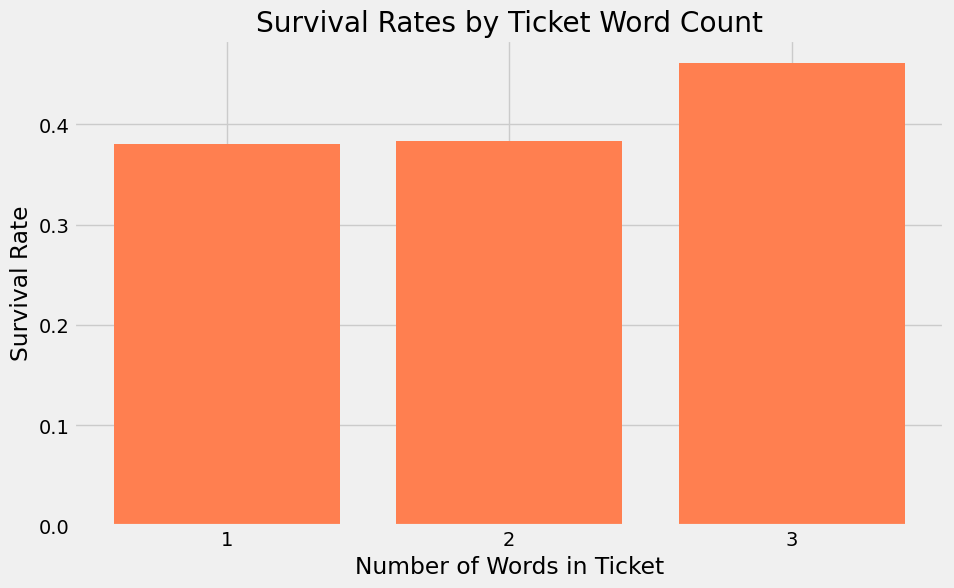

In [6]:
df['Ticket_Word_Count'] = df['Ticket'].str.split().str.len()
df_test['Ticket_Word_Count'] = df_test['Ticket'].str.split().str.len()

survival_rates = df.groupby('Ticket_Word_Count')['Survived'].mean()

fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(df['Ticket_Word_Count'].unique(), survival_rates, color='coral')

plt.plot()

plt.title('Survival Rates by Ticket Word Count')
plt.xlabel('Number of Words in Ticket')
plt.ylabel('Survival Rate')
plt.xticks(df['Ticket_Word_Count'].unique()) 

plt.grid(True)
plt.show()

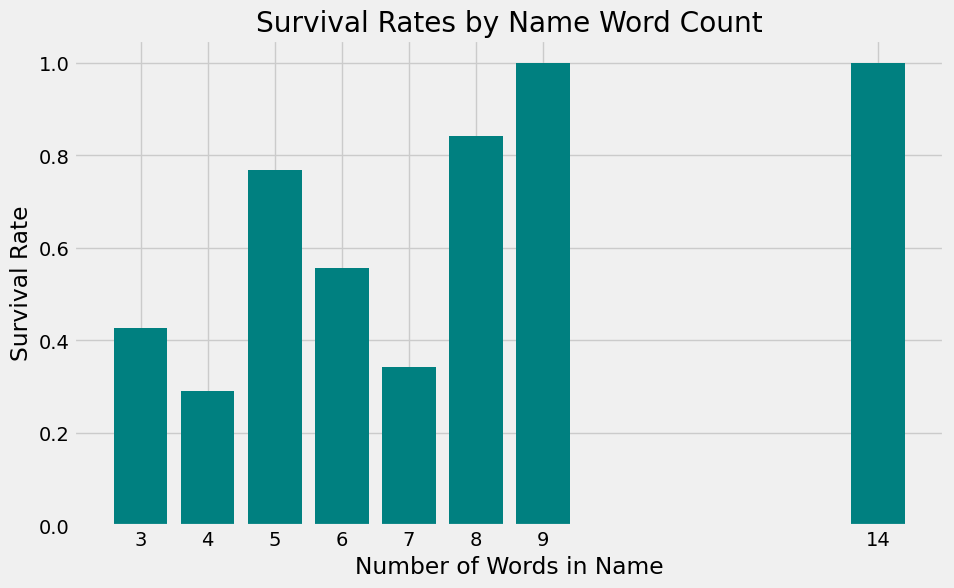

In [7]:
df['Name_Word_Count'] = df['Name'].str.split().str.len()
df_test['Name_Word_Count'] = df_test['Name'].str.split().str.len()

survival_rates = df.groupby('Name_Word_Count')['Survived'].mean()

fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(df['Name_Word_Count'].unique(), survival_rates, color='teal')

plt.plot()

plt.title('Survival Rates by Name Word Count')
plt.xlabel('Number of Words in Name')
plt.ylabel('Survival Rate')
plt.xticks(df['Name_Word_Count'].unique()) 

plt.grid(True)
plt.show()

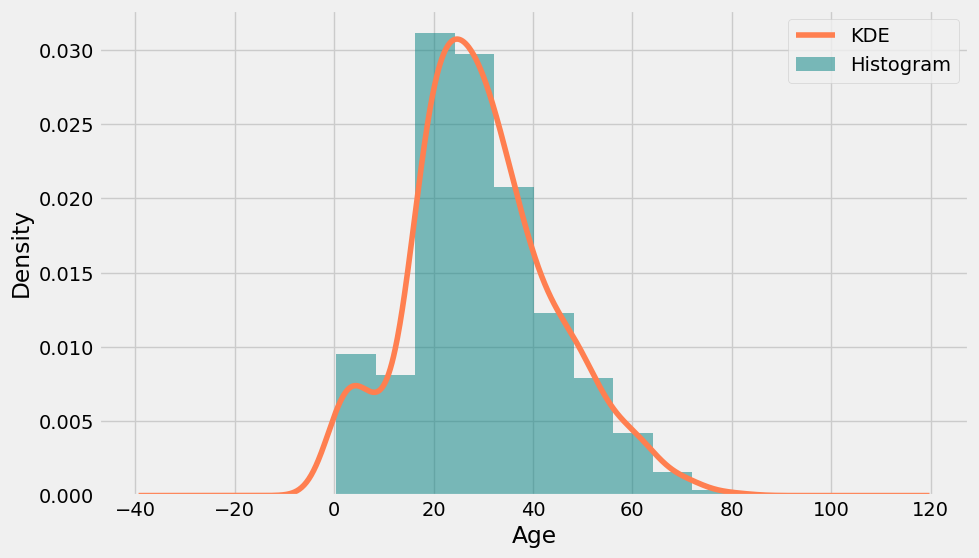

In [8]:
fig, ax = plt.subplots(figsize=(10,6))

df['Age'].plot(kind='kde', ax=ax, label='KDE', color='coral')
df['Age'].plot(kind='hist', ax=ax, density=True, alpha=0.5, label='Histogram', color='teal')

ax.set_ylabel('Density')
ax.set_xlabel('Age')
ax.legend()

plt.show()


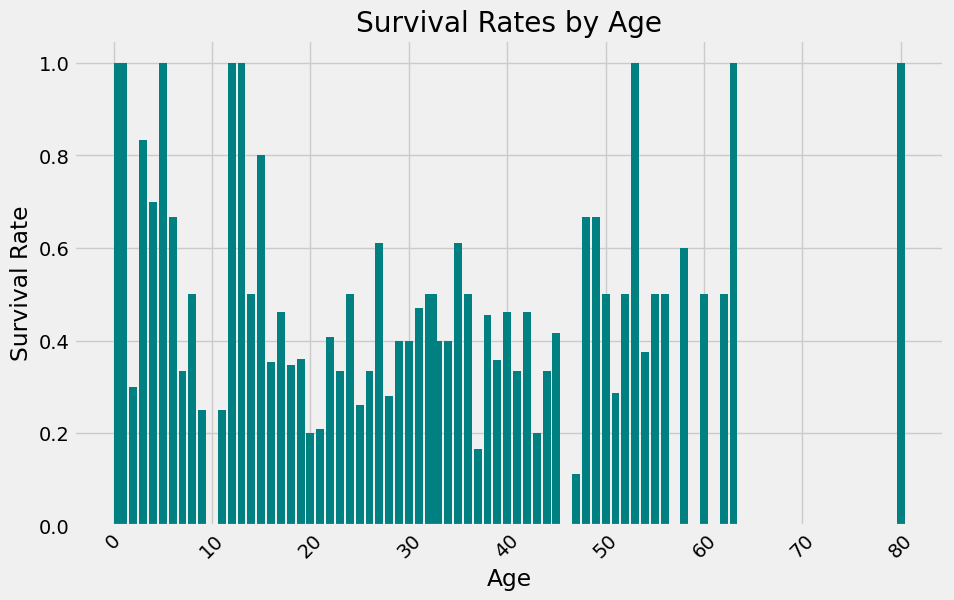

In [9]:
survival_rates = df.groupby('Age')['Survived'].mean()
unique_ages = survival_rates.index.dropna().sort_values() 

fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(unique_ages, survival_rates.loc[unique_ages], color='teal')
plt.title('Survival Rates by Age')
plt.xlabel('Age')
plt.ylabel('Survival Rate')
plt.xticks(rotation=45)  

plt.grid(True)
plt.show()

In [10]:
df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=True)
df_test['Title'] = df_test['Name'].str.extract('([A-Za-z]+)\.', expand=True)

def extract_last_name_custom(text):
    match = re.search(r'(\w+),|(\w+)\s+\w+\.', text)
    if match:
        return match.group(1) or match.group(2)
    return None

df['LastName'] = df['Name'].apply(extract_last_name_custom)
df_test['LastName'] = df_test['Name'].apply(extract_last_name_custom)

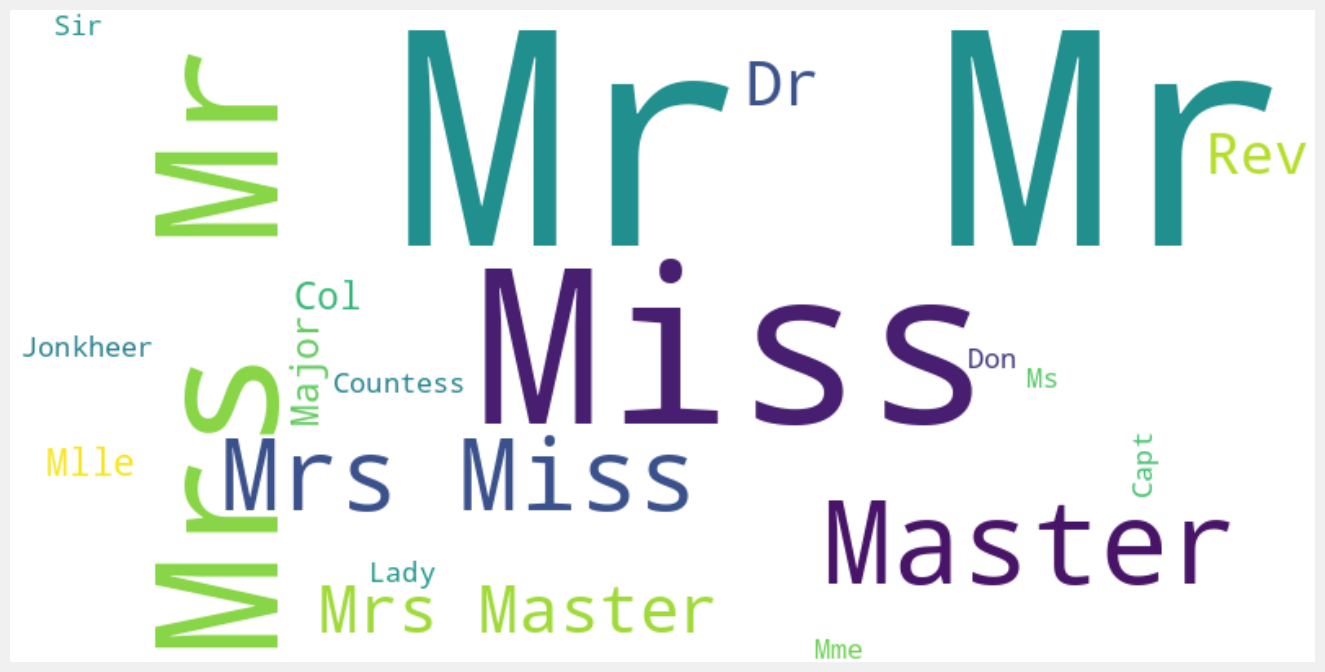

In [11]:
all_titles = ' '.join(df['Title'].dropna())  

wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(all_titles)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  
plt.show()

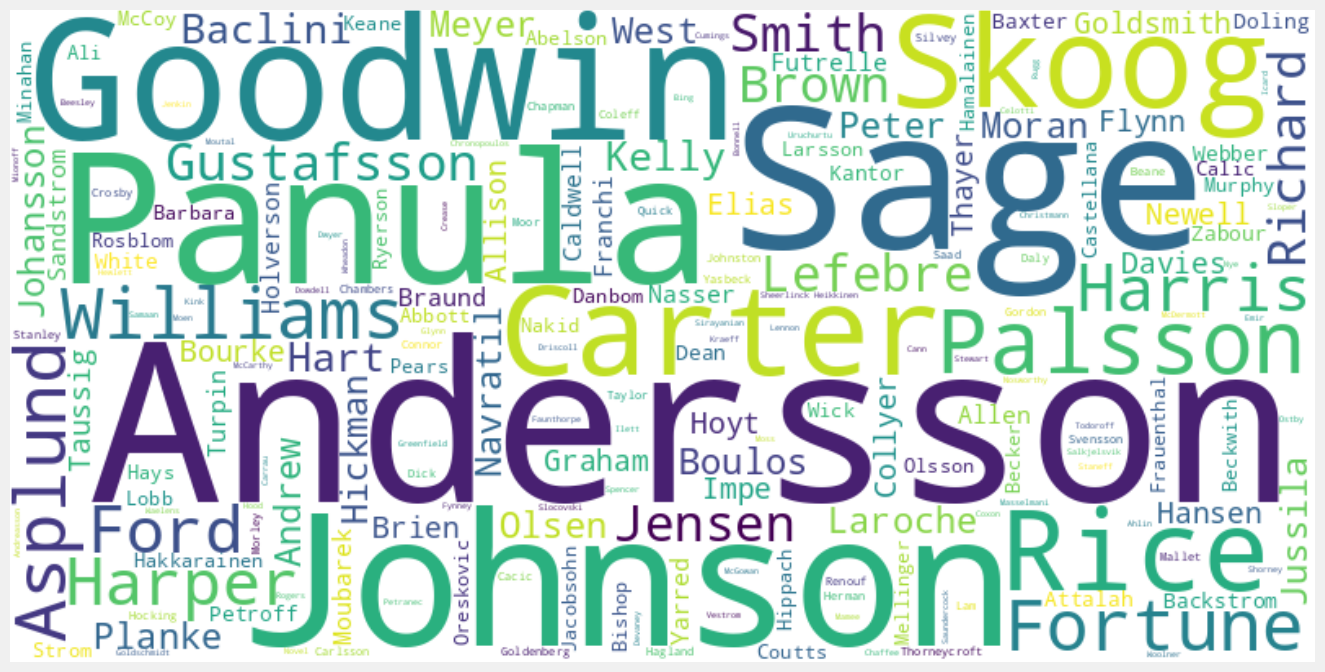

In [12]:
all_last_names = ' '.join(df['LastName'].dropna())  

wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(all_last_names)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  
plt.show()

/tmp/ipykernel_19/3241333904.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Sex'] = df['Sex'].replace({'male': 0, 'female': 1})
/tmp/ipykernel_19/3241333904.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['Sex'] = df_test['Sex'].replace({'male': 0, 'female': 1})


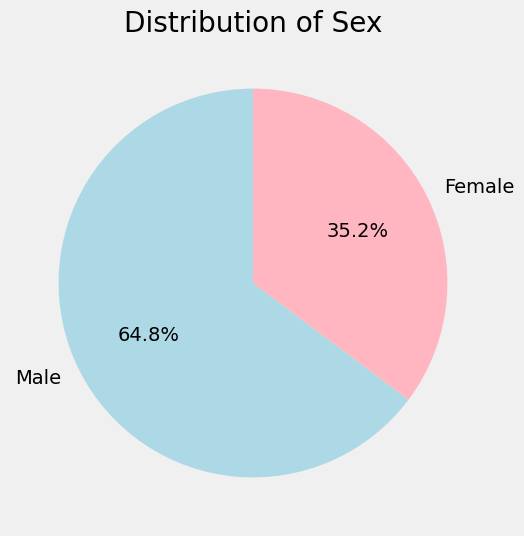

In [13]:
df['Sex'] = df['Sex'].replace({'male': 0, 'female': 1})
df_test['Sex'] = df_test['Sex'].replace({'male': 0, 'female': 1})
sex_counts = df['Sex'].value_counts()


fig, ax = plt.subplots(figsize=(10, 6))
sex_counts.plot(kind='pie', ax=ax, labels=['Male', 'Female'], autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightpink'])

ax.set_ylabel('') 
ax.set_title('Distribution of Sex')

plt.show()

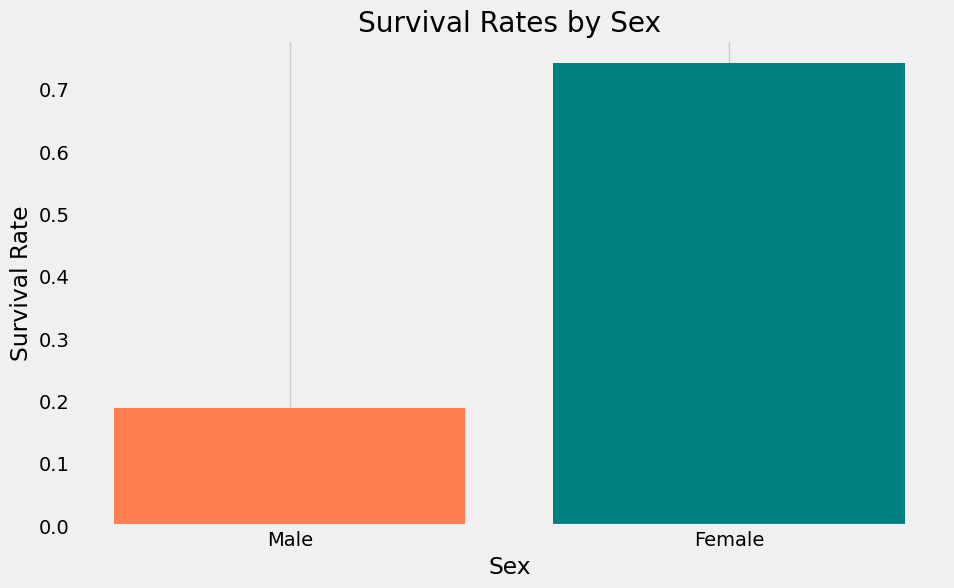

In [14]:
survival_rates = df.groupby('Sex')['Survived'].mean()

fig, ax = plt.subplots(figsize=(10, 6))

plt.bar(survival_rates.index, survival_rates, color=['coral', 'teal'])
plt.title('Survival Rates by Sex')
plt.xlabel('Sex')
plt.ylabel('Survival Rate')
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])
plt.grid(axis='y') 

plt.show()

In [15]:
df.drop(['Cabin', 'PassengerId', 'Ticket', 'Name'], axis=1, inplace=True)
df_test.drop(['Cabin', 'PassengerId', 'Ticket', 'Name'], axis=1, inplace=True)

In [16]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket_Word_Count,Name_Word_Count,Title,LastName
0,0,3,0,22.0,1,0,7.2500,S,2,4,Mr,Braund
1,1,1,1,38.0,1,0,71.2833,C,2,7,Mrs,Cumings
2,1,3,1,26.0,0,0,7.9250,S,2,3,Miss,Heikkinen
3,1,1,1,35.0,1,0,53.1000,S,1,7,Mrs,Futrelle
4,0,3,0,35.0,0,0,8.0500,S,1,4,Mr,Allen
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,S,1,3,Rev,Montvila
887,1,1,1,19.0,0,0,30.0000,S,1,4,Miss,Graham
888,0,3,1,NaN,1,2,23.4500,S,2,5,Miss,Johnston
889,1,1,0,26.0,0,0,30.0000,C,1,4,Mr,Behr


In [17]:
high_cat_cols = ['LastName']
low_cat_cols = ['Title', 'Embarked']

cat_cols = high_cat_cols + low_cat_cols
numerical_cols = [col for col in df.columns if col not in cat_cols and col != 'Survived']

In [18]:
y = df['Survived']
X = df.drop(['Survived'], axis=1)

column_transformer = ColumnTransformer(
    transformers=[
        ('encoder', BinaryEncoder(), cat_cols)
    ],
    remainder="passthrough"  
)

pipeline = Pipeline(steps=[
    ('ct', column_transformer),
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
        random_state=2002, use_label_encoder=False, eval_metric='logloss',
        colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3,
        min_child_weight=1, n_estimators=400
    )) 
])


# tuning_params = {
#     'imputer__n_neighbors': [3, 5, 7],
#     'imputer__weights': ['uniform', 'distance'],
#     'xgb__n_estimators': [100, 200, 300],
#     'xgb__learning_rate': [0.01, 0.1, 0.2],
#     'xgb__max_depth': [3, 4, 5],
#     'xgb__min_child_weight': [1, 2, 3],  # Similar to min_samples_leaf
#     'xgb__gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition
#     'xgb__subsample': [0.8, 0.9, 1.0],
#     'xgb__colsample_bytree': [0.8, 0.9, 1.0],  # Similar to max_features
# }


# tuning_params = {
#     'imputer__n_neighbors': [3, 5, 7],  
#     'imputer__weights': ['uniform', 'distance'],  
#     'logreg__C': np.logspace(-4, 4, 10),
#     'logreg__solver': ['liblinear', 'saga'],
#     'logreg__penalty': ['l1', 'l2'],  
#     'logreg__max_iter': [5000, 10000, 20000], 
# }

# clf = RandomizedSearchCV(pipeline, tuning_params, cv=5, verbose=0, scoring='accuracy')

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_model = pipeline.fit(X_train, Y_train)

Y_pred = best_model.predict(X_test)
Y_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
roc_auc = roc_auc_score(Y_test, Y_proba)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC Score: {roc_auc}")

Accuracy: 0.8379888268156425
Precision: 0.8571428571428571
Recall: 0.7297297297297297
F1 Score: 0.7883211678832117
ROC-AUC Score: 0.8850707850707851


In [19]:
# best_model.best_estimator_

In [20]:
prediction = pipeline.predict(df_test)

len(prediction)

418

In [21]:
passengerIds = [x for x in range(892, 1310)]

prediction_df = pd.DataFrame({'PassengerId': passengerIds, 'Survived': prediction})

prediction_df['Survived'] = prediction_df['Survived'].astype(int)

prediction_df.to_csv('submission.csv', index=False)